In [431]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


%matplotlib inline

<h3> Import cleaned dataset. Drop non-predictive features and set 
display options to suit our large amount of features</h3>

In [368]:
# for now, df is created from original dataset
# should be replaced by cleaned version once quality plan is complete
df = pd.read_csv('OnlineNewsPopularityCleaned.csv', skipinitialspace=True)
pd.options.display.max_columns = None
pd.options.display.max_rows = None
# could try leaving timedelta in for the random forests, because if it is worthless
# random forests algo will just ignore
df = df.drop(['url', 'timedelta'], axis=1)
# drop non-predictive features 
shuffle(df)
# shuffle df in case there is a pattern to how rows were inserted 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [349]:
# split df into X (descriptive features) and y (target feature)
X = df.drop(['shares'], axis=1)   
y = df['shares']

In [350]:
# further split into training and testing sets for convenient use with sklearn models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

<h3> As the target is a continuous value, will first try RandomForestRegressor. Starting with a baseline model, using all predictive features of the dataset, and all default params for the model. </h3>

In [351]:
rf_baseline = RandomForestRegressor(n_estimators=100, oob_score=True)

In [352]:
rf_baseline.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [354]:
# appears to be a very poor score. (from what i understand, oob score is an estimated r2 score when testing the model
# on the 'out of bag' rows - those not used in any of the random samples assembled in the bagging process)
rf_baseline.oob_score_

-0.089992946569479981

In [325]:
# get a mean absolute error to get another check of model accuracy (using mae because, from my current understanding,
# it's less sensitive to outliers that mse)

In [381]:
mae = median_absolute_error(y_test[:500], rf_baseline.oob_prediction_[:500])
mae

1479.3732078853045

In [ ]:
# to get perspective on this figure, i will look closer at the target feature.

In [327]:
# high std deviation - triple the mean value. 
# this skewed distribution makes sense, given the nature of the target feature - viral popularity is related to a
# network effect which results in something like exponential growth of social media shares past a certain point. 
y.describe()

count     38463.000000
mean       3355.360398
std       11585.968776
min           1.000000
25%         945.000000
50%        1400.000000
75%        2700.000000
max      843300.000000
Name: shares, dtype: float64

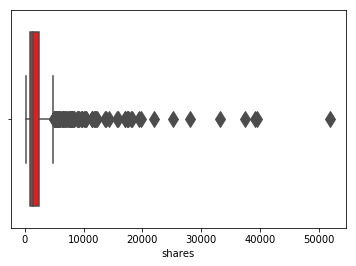

In [356]:
# visualise the target feature for clarifications of the distribution pattern discussed above.
# the boxplot shows the extremely skewed distribution of the target feature. a large number of samples (covering the 
# large majority of the range) are classed as outliers. will try removing outliers from the target and use it for 
# a new model iteration
sns.boxplot(x=y[:1000], color='red', fliersize=12)

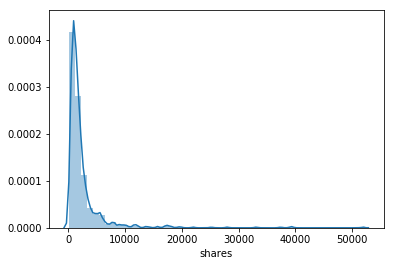

In [364]:
# very strongly right-skewed distribution is apparent. although random forests is said to be relatively insensitive to
# outliers, perhaps this case is too extreme. 
sns.distplot(y[:1000])

<h3> New model iteration, using the updated target feature. </h3>

In [369]:
# drop outliers from target (identified in box plot below)
df = df.drop(df[df['shares'] > 5000].index)

In [371]:
# re-assign train test variables to reflect updated df.
X = df.drop(['shares'], axis=1)   
y = df['shares']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [372]:
rf_outliers_dropped = RandomForestRegressor(n_estimators=100, oob_score=True)

In [373]:
rf_outliers_dropped.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [382]:
mae = median_absolute_error(y_test[:500], rf_outliers_dropped.oob_prediction_[:500])
mae

737.06616541353389

In [379]:
# big improvement, but mae still seems very high in relation to the mean
df['shares'].mean()

1614.346122958865

In [385]:
# attempt to calculate accuracy from mae. fairly poor accuracy rate. 
mae = median_absolute_error(y_train, rf_outliers_dropped.oob_prediction_)
100 - ((mae/y_test.median()) * 100)

55.327543424317618

<h3> Using a randomised search grid to find the optimal parameters for the model </h3>

In [122]:
# using a randomised search rather than normal grid search to save processing time (will just be testing a 
# random selection of permutations)
# for this project, will just be testing for ideal n_estimators (number of trees) and max_depth (max tree depth)
grid = {'n_estimators': [10, 50, 100, 150, 200, 500, 1000], 'max_depth': [2,4,6,10,15,None]}

In [123]:
rf_reg = RandomForestRegressor()

In [83]:
# please note: the next two cells TAKE APPROX 30 MINS TO RUN. results should be visible on opening the notebook.
# n_jobs set to -1 to allow all available cores to help with processing time.
rf_reg_random = RandomizedSearchCV(estimator = rf_reg, param_distributions = grid, n_iter = 30, cv=3, n_jobs = -1)

In [84]:
rf_reg_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=30, n_jobs=-1,
          param_distributions={'n_estimators': [10, 50, 100, 150, 200, 500, 1000], 'max_depth': [2, 4, 6, 10, 15, None]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [85]:
# based on the randomised search, the following are considered to be the best parameter settings
rf_reg_random.best_params_

{'max_depth': 2, 'n_estimators': 200}

In [386]:
# new model, using optimal params
rf_best_params = RandomForestRegressor(n_estimators=200, max_depth=2, oob_score=True, n_jobs=-1)

In [387]:
rf_best_params.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [390]:
# a further improvement on the mae, but still seems too high.
mae = median_absolute_error(y_test[:500], rf_best_params.oob_prediction_[:500])
mae

684.87217697072208

In [402]:
# a comparison of a sample of predictions and actual values
# aside from the generally poor success rate, it is noticeable how much less variance there is
# in the predictions, when compared with the true values. could this still be the effects of
# the very widely-spaced distribution of the target feature? 
predictions_sample = rf_best_params.predict(X_test)[:15]
true_vals_sample = y_test[:15]
pd.DataFrame({'Predicted':predictions_sample, 'Actual': true_vals_sample})

,Actual,Predicted
6658,5000,1888.164112
26805,811,1374.547724
13593,1500,1884.554239
7388,1600,1888.164112
27843,1200,1883.476675
14069,834,1374.547724
26982,882,1378.516799
11569,889,1453.408074
15697,1300,1374.547724
34059,839,1381.683083


<h3>New approach: use Random Forests Classifier to check if I can have more success treating this as a classification problem</h3>

In [451]:
# new model, using params found in randomised search (see above). if i had more time, would run a separate search,
# in case ideal params would be different for the classifier model. 
rf_cls = RandomForestClassifier(n_estimators=200, max_depth=2, oob_score=True)

In [452]:
# convert the target feature to binary categories. initially using just the median value
# as a threshold. 1 means popular (above the median) and 0 not popular.
df['shares_binary'] = np.where(df['shares'] >=df['shares'].median(), 1, 0)

In [453]:
X = df.drop(['shares_binary', 'shares'], axis=1)

In [454]:
y = df['shares_binary']

In [457]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [458]:
rf_cls.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [459]:
# accuracy initially seems ok, but when evaluated against the test set, significant overfitting is apparent.
rf_cls_predictions = rf_cls.predict(X_train)[:1000]

print("Accuracy (training set): ", accuracy_score(y_train[:1000], rf_cls_predictions))
print("Confusion matrix (training samples): \n", confusion_matrix(y_train[:1000], rf_cls_predictions))
print("Classification report (training samples):\n ", classification_report(y_train[:1000], rf_cls_predictions))

Accuracy (training set):  0.646
Confusion matrix (training samples): 
 [[256 216]
 [138 390]]
Classification report (training samples):
               precision    recall  f1-score   support

          0       0.65      0.54      0.59       472
          1       0.64      0.74      0.69       528

avg / total       0.65      0.65      0.64      1000



In [438]:
print("Accuracy (test set): ", accuracy_score(y_test[:1000], rf_cls_predictions))
print("Confusion matrix (test set): \n", confusion_matrix(y_test[:1000], rf_cls_predictions))
print("Classification report (test set):\n ", classification_report(y_test[:1000], rf_cls_predictions))

Accuracy (test set):  0.496
Confusion matrix (test set): 
 [[179 282]
 [222 317]]
Classification report (test set):
               precision    recall  f1-score   support

          0       0.45      0.39      0.42       461
          1       0.53      0.59      0.56       539

avg / total       0.49      0.50      0.49      1000



In [ ]:
# the above figures are disappointing, so will try another randomised search grid to find best 
# params for this classifier model


<h3> Using a randomised search grid to find the optimal parameters for the model </h3>

In [441]:
grid = {'n_estimators': [10, 50, 100, 150, 200, 500, 1000], 'max_depth': [2,4,6,10,15,None]}

In [461]:
rf_cls = RandomForestClassifier()

In [462]:
rf_cls_random = RandomizedSearchCV(estimator = rf_cls, param_distributions = grid, n_iter = 20, cv=3, n_jobs = -1)

In [463]:
# WARNING: takes 20-30 mins to run. results should be displayed below on load.
rf_cls_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': [10, 50, 100, 150, 200, 500, 1000], 'max_depth': [2, 4, 6, 10, 15, None]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [464]:
rf_cls_random.best_params_

{'max_depth': 15, 'n_estimators': 1000}

In [465]:
rf_cls_best_params = RandomForestClassifier(n_estimators=1000, max_depth=15, oob_score=True, n_jobs=-1)

In [466]:
rf_cls_best_params.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [467]:
# severe overfitting on this model iteration. not successful.
cls_best_params_predictions = rf_cls_best_params.predict(X_train)[:1000]

print("Accuracy (training set): ", accuracy_score(y_train[:1000], cls_best_params_predictions))
print("Confusion matrix (training samples): \n", confusion_matrix(y_train[:1000], cls_best_params_predictions))
print("Classification report (training samples):\n ", classification_report(y_train[:1000], cls_best_params_predictions))

Accuracy (training set):  0.962
Confusion matrix (training samples): 
 [[456  16]
 [ 22 506]]
Classification report (training samples):
               precision    recall  f1-score   support

          0       0.95      0.97      0.96       472
          1       0.97      0.96      0.96       528

avg / total       0.96      0.96      0.96      1000



In [468]:
print("Accuracy (test set): ", accuracy_score(y_test[:1000], cls_best_params_predictions))
print("Confusion matrix (test set): \n", confusion_matrix(y_test[:1000], cls_best_params_predictions))
print("Classification report (test set):\n ", classification_report(y_test[:1000], cls_best_params_predictions))

Accuracy (test set):  0.492
Confusion matrix (test set): 
 [[235 265]
 [243 257]]
Classification report (test set):
               precision    recall  f1-score   support

          0       0.49      0.47      0.48       500
          1       0.49      0.51      0.50       500

avg / total       0.49      0.49      0.49      1000



<h3>Summary</h3>

At this stage, none of the models are satisfactory. Given more time, I would look into ways to deal with a target feature with such a skewed distribution. In experiments not documented in this Notebook, I tested models with even lower outlier cut-offs and found that the more I eliminated the widely spaced upper end of the values, the better a success rate the model seemed to have. However, this quickly got to the point where the true nature of the dataset was being eroded and the potential usefulness of the model was fading. I'm sure that with more experience in the field I would have other ideas as to how to handle this problem.

<h3>One final experiment...</h3>

In [406]:
# features ranked by importance
# we used this table to select features for a linear regression model
# see linear regression notebook for results...
f_imps = pd.DataFrame({'feature': X.columns, 'importance':rf_best_params.feature_importances_})
f_imps.sort_values(by=['importance'], ascending=False)

,feature,importance
25,kw_avg_avg,0.537719
12,data_channel_is_entertainment,0.278287
15,data_channel_is_tech,0.139244
36,is_weekend,0.031236
14,data_channel_is_socmed,0.003954
28,self_reference_avg_sharess,0.003301
26,self_reference_min_shares,0.002660
41,LDA_04,0.002019
21,kw_max_max,0.000826
22,kw_avg_max,0.000754


Deployment
1.How will the model be integrated into the organisation?
Mashable faces a choice in how to integrate the model. Given our findings on the importance of links to other popular articles and keywords shared with other popular articles, they could either 'chase popularity' by sticking to these popular networks - or they could risk occasionally producing more innovative topics that might strike a chord with readers but might struggle algorithmically to generate shares, at least in the short term.

With regard to the popular LDA topics 2 and 3, articles scoring close to these topics could be studied to get a sense of what is popular in terms of style and article content - this knowledge could then be used to influence what work editors commission in future.

Furthermore, although timing of publication and word count did not feature among the most influential features, in certain cases an editor might wish to look at them to judge which day and time to post a piece to reach the maximum audience possible (all other things being equal), so some further research into this might allow enable the deployment of such knowledge.

2.How will we continue to evaluate the model after deployment?
We would recommend updating the model with new data from Mashable as time goes on as trends and public tastes may change.